# **Algorithmic Methods for Data Mining: Homework 4**

**Author:** Roberto Magno Mazzotta , xxx

*MSc. in Data Science, Sapienza University of Rome*

---

## **0. Uploading the Classes and Modules**

Before doing any kind of analysis it is necessary to upload both the relevant Classes and Modules we will use to work.

In [3]:
from libs.analysis_functions import (
    initialize_spark, load_data, preprocess_movies_ratings,
    calculate_avg_ratings_by_genre, calculate_ratings_by_year,
    inspect_data, save_to_csv, merge_datasets
)
import matplotlib.pyplot as plt

# Initialize Spark
spark = initialize_spark()

# Define dataset path
path = "/Users/roberto/Desktop/HM4-ADM/datasets"

# Load Data
tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df = load_data(spark, path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 17:39:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---

## **1. Recommendation System**

In this homework, we were asked to implement our version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input a user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

### **1.1. The Dataset**

We were provided with a [dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=rating.csv) that describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. 

It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

This dataset (according to its Kaggle description):

> Describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. 
    > - It contains 20000263 ratings and 465564 tag applications across 27278 movies.
    > -  These data were created by 138493 users between January 09, 1995 and March 31, 2015. 
    

Users were selected at random for inclusion. All selected users had rated at least 20 movies.

Content
No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files.


- **tag.csv**: contains tags applied to movies by users:
    - userId

    - movieId

    - tag

    - timestamp

- **rating.csv**: contains ratings of movies by users:
    - userId

    - movieId

    - rating

    - timestamp

- **movie.csv**: contains movie information:
    - movieId

    - title

    - genres

- **link.csv**: contains identifiers that can be used to link to other sources:
    - movieId

    - imdbId

    - tmbdId

- **genome_scores.csv**: contains movie-tag relevance data:
    - movieId

    - tagId

    - relevance
- **genome_tags.csv**: contains tag descriptions:

    - tagId

    - tag



In [2]:
# Inspect the structure and content of the loaded DataFrames
print("Inspecting rating_df:")
inspect_data(rating_df, num_rows=10)  # Display top 10 rows of ratings

print("Inspecting movie_df:")
inspect_data(movie_df, num_rows=5)  # Display top 5 rows of movies

# Convert to Pandas for detailed inspection
movies_sample = inspect_data(movie_df, num_rows=5, convert_to_pandas=True)
print(movies_sample)

Inspecting rating_df:
+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
|     1|    112|   3.5|2004-09-10 03:09:00|
|     1|    151|   4.0|2004-09-10 03:08:54|
|     1|    223|   4.0|2005-04-02 23:46:13|
|     1|    253|   4.0|2005-04-02 23:35:40|
|     1|    260|   4.0|2005-04-02 23:33:46|
+------+-------+------+-------------------+
only showing top 10 rows

Inspecting movie_df:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|  

In [3]:
# Preprocess movies and ratings data
movies_ratings_df = preprocess_movies_ratings(movie_df, rating_df)

# Inspect preprocessed data
print("Inspecting movies_ratings_df after preprocessing:")
inspect_data(movies_ratings_df, num_rows=5)

# Calculate average ratings by genre
avg_ratings_by_genre = calculate_avg_ratings_by_genre(movies_ratings_df)

# Calculate ratings by year
ratings_by_year = calculate_ratings_by_year(movies_ratings_df)

Inspecting movies_ratings_df after preprocessing:
+-------+--------------------+--------------------+------+------+-------------------+----+---------+
|movieId|               title|              genres|userId|rating|          timestamp|year|    genre|
+-------+--------------------+--------------------+------+------+-------------------+----+---------+
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|Adventure|
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005| Children|
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|  Fantasy|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|Adventure|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|    Drama|
+-------+--------------------+--------------------+------+------+-------------------+----+---------+
only showing top 5 rows



- **Merge the Dataset** :

The six files contain complementary information that can be combined using shared keys like **userId**, **movieId**, and **tagId**. Below is an explanation of each file’s role and how they are merged to form a unified dataset.

In [2]:
import libs

In [4]:
from libs.analysis_functions import merge_datasets

In [5]:
# Import necessary modules
from libs.analysis_functions import initialize_spark, load_data, merge_datasets, inspect_data

# Initialize Spark session
spark = initialize_spark()

# Load datasets
path = "/Users/roberto/Desktop/HM4-ADM/datasets"  # Update with the actual path to your dataset
tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df = load_data(spark, path)

# Merge datasets into a single DataFrame
final_dataset = merge_datasets(tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df)

# Visualize the merged dataset
print("Dataset Schema:")
final_dataset.printSchema()  # Display the schema of the DataFrame

print("\nSample Rows:")
final_dataset.show(10)  # Display the first 10 rows of the dataset

Dataset Schema:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = false)
 |-- rating: double (nullable = true)
 |-- rating_timestamp: timestamp (nullable = true)
 |-- user_tag: string (nullable = false)
 |-- tag_timestamp: timestamp (nullable = true)
 |-- tagId: integer (nullable = true)
 |-- relevance: double (nullable = false)
 |-- genome_tag: string (nullable = true)
 |-- rating_date: date (nullable = true)


Sample Rows:


+-------+------+--------------------+------------------+------+-------------------+--------+-------------+-----+---------+------------+-----------+
|movieId|userId|               title|            genres|rating|   rating_timestamp|user_tag|tag_timestamp|tagId|relevance|  genome_tag|rating_date|
+-------+------+--------------------+------------------+------+-------------------+--------+-------------+-----+---------+------------+-----------+
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    1|  0.04275|         007| 1999-10-23|
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    2|  0.05125|007 (series)| 1999-10-23|
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    3|  0.02875|18th century| 1999-10-23|
|   2659| 70324|It Came from Holl...|Comedy|Documentary|   4.0|1999-10-23 10:54:57|  No Tag|         NULL|    4|

In [2]:
# Display dataset schema and sample rows for a better understanding of columns and structure

# Tag Dataset
print("Tag Dataset Schema:")
tag_df.printSchema()
print("\nSample Rows from Tag Dataset:")
tag_df.show(5)

# Rating Dataset
print("\nRating Dataset Schema:")
rating_df.printSchema()
print("\nSample Rows from Rating Dataset:")
rating_df.show(5)

# Movie Dataset
print("\nMovie Dataset Schema:")
movie_df.printSchema()
print("\nSample Rows from Movie Dataset:")
movie_df.show(5)

# Link Dataset
print("\nLink Dataset Schema:")
link_df.printSchema()
print("\nSample Rows from Link Dataset:")
link_df.show(5)

# Genome Scores Dataset
print("\nGenome Scores Dataset Schema:")
genome_scores_df.printSchema()
print("\nSample Rows from Genome Scores Dataset:")
genome_scores_df.show(5)

# Genome Tags Dataset
print("\nGenome Tags Dataset Schema:")
genome_tags_df.printSchema()
print("\nSample Rows from Genome Tags Dataset:")
genome_tags_df.show(5)

# Merged Dataset
print("\nMerged Dataset Schema:")
final_dataset.printSchema()
print("\nSample Rows from Merged Dataset:")
final_dataset.show(10)

# Display Summary Statistics
print("\nSummary Statistics for Merged Dataset:")
final_dataset.describe().show()

# Column Analysis
print("\nColumn Names and Data Types in the Merged Dataset:")
for col_name, dtype in final_dataset.dtypes:
    print(f"{col_name}: {dtype}")

Tag Dataset Schema:


NameError: name 'tag_df' is not defined

In [6]:
print("Merged Dataset Schema:")
final_dataset.printSchema()

Merged Dataset Schema:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = false)
 |-- rating: double (nullable = true)
 |-- rating_timestamp: timestamp (nullable = true)
 |-- user_tag: string (nullable = false)
 |-- tag_timestamp: timestamp (nullable = true)
 |-- tagId: integer (nullable = true)
 |-- relevance: double (nullable = false)
 |-- genome_tag: string (nullable = true)
 |-- rating_date: date (nullable = true)



In [4]:
# Schema and sample rows for each dataset
datasets = {"Tag Dataset": tag_df, "Rating Dataset": rating_df, "Movie Dataset": movie_df,
            "Link Dataset": link_df, "Genome Scores Dataset": genome_scores_df, "Genome Tags Dataset": genome_tags_df}

for name, dataset in datasets.items():
    print(f"\n{name} Schema:")
    dataset.printSchema()
    print(f"\nSample Rows from {name}:")
    dataset.show(5)


Tag Dataset Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)


Sample Rows from Tag Dataset:
+------+-------+-------------+-------------------+
|userId|movieId|          tag|          timestamp|
+------+-------+-------------+-------------------+
|    18|   4141|  Mark Waters|2009-04-24 18:19:40|
|    65|    208|    dark hero|2013-05-10 01:41:18|
|    65|    353|    dark hero|2013-05-10 01:41:19|
|    65|    521|noir thriller|2013-05-10 01:39:43|
|    65|    592|    dark hero|2013-05-10 01:41:18|
+------+-------+-------------+-------------------+
only showing top 5 rows


Rating Dataset Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)


Sample Rows from Rating Dataset:
+------+-------+------+-------------------+
|userId|movieId|rating|        

In [5]:
tag_df = tag_df.withColumnRenamed("tag", "user_tag")
genome_tags_df = genome_tags_df.withColumnRenamed("tag", "genome_tag")

In [7]:
from pyspark.sql.functions import col  # Add this import to resolve the NameError

# Ensure movieId and tagId columns are cast to integer type
tag_df = tag_df.withColumn("movieId", col("movieId").cast("integer"))
genome_scores_df = genome_scores_df.withColumn("movieId", col("movieId").cast("integer"))
genome_tags_df = genome_tags_df.withColumn("tagId", col("tagId").cast("integer"))

3. Merging Datasets

	- 	Datasets like ratings, movies, 	tags, and genome_scores require joins on movieId or tagId.
	- 	Use appropriate join types:
	-	Inner Join: When both datasets must have matching records (e.g., ratings and movies).
	-	Left Join: When we want all records from one dataset and matching records from another (e.g., tags with movies).

In [9]:
user_movie_df = movie_df.join(rating_df, "movieId", "inner")
user_movie_df = user_movie_df.join(tag_df, ["userId", "movieId"], "left")
genome_df = genome_scores_df.join(genome_tags_df, "tagId", "inner")

4. Null Handling

	-	Fill null or missing values for key columns:
	-	genres: Replace with "Unknown".
	-	user_tag and genome_tag: Replace with "No Tag".
	-	relevance: Replace with 0.0.

In [8]:
final_dataset = merge_datasets(tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df)

In [9]:
print("Columns in Final Dataset:")
final_dataset.printSchema()

Columns in Final Dataset:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = false)
 |-- rating: double (nullable = true)
 |-- rating_timestamp: timestamp (nullable = true)
 |-- user_tag: string (nullable = false)
 |-- tag_timestamp: timestamp (nullable = true)
 |-- tagId: integer (nullable = true)
 |-- relevance: double (nullable = false)
 |-- genome_tag: string (nullable = true)
 |-- rating_date: date (nullable = true)



In [10]:
final_dataset = final_dataset.fillna({
    "user_tag": "No Tag",
    "genome_tag": "No Tag",
    "genres": "Unknown",
    "relevance": 0.0
})

In [11]:
print("Final Dataset Schema:")
final_dataset.printSchema()

Final Dataset Schema:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = false)
 |-- rating: double (nullable = true)
 |-- rating_timestamp: timestamp (nullable = true)
 |-- user_tag: string (nullable = false)
 |-- tag_timestamp: timestamp (nullable = true)
 |-- tagId: integer (nullable = true)
 |-- relevance: double (nullable = false)
 |-- genome_tag: string (nullable = false)
 |-- rating_date: date (nullable = true)



In [13]:
# View the first few rows to confirm the data
print("Sample Rows from Final Dataset:")
final_dataset.show(10)

# Describe numeric columns
print("\nSummary Statistics for Numeric Columns:")
final_dataset.describe(["rating", "relevance"]).show()

# Check for missing values
print("\nCount of Null Values in Each Column:")
final_dataset.select([col(c).isNull().alias(c) for c in final_dataset.columns]).agg(
    *(count(c).alias(c) for c in final_dataset.columns)
).show()

Sample Rows from Final Dataset:


ConnectionRefusedError: [Errno 61] Connection refused

In [14]:
# Count ratings by value
print("Ratings Distribution:")
final_dataset.groupBy("rating").count().orderBy("rating").show()

Ratings Distribution:


ConnectionRefusedError: [Errno 61] Connection refused

<Figure size 1000x600 with 0 Axes>

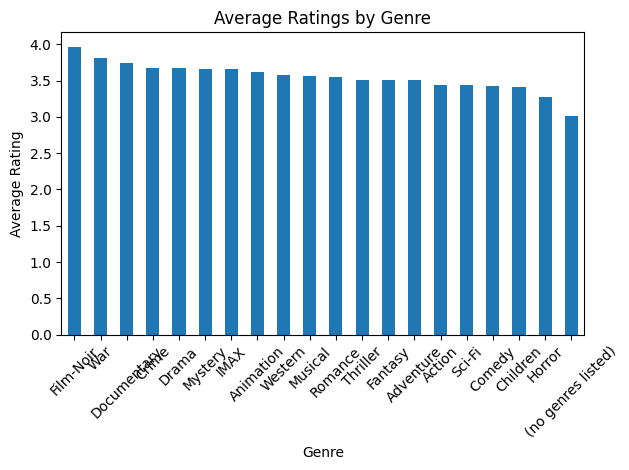

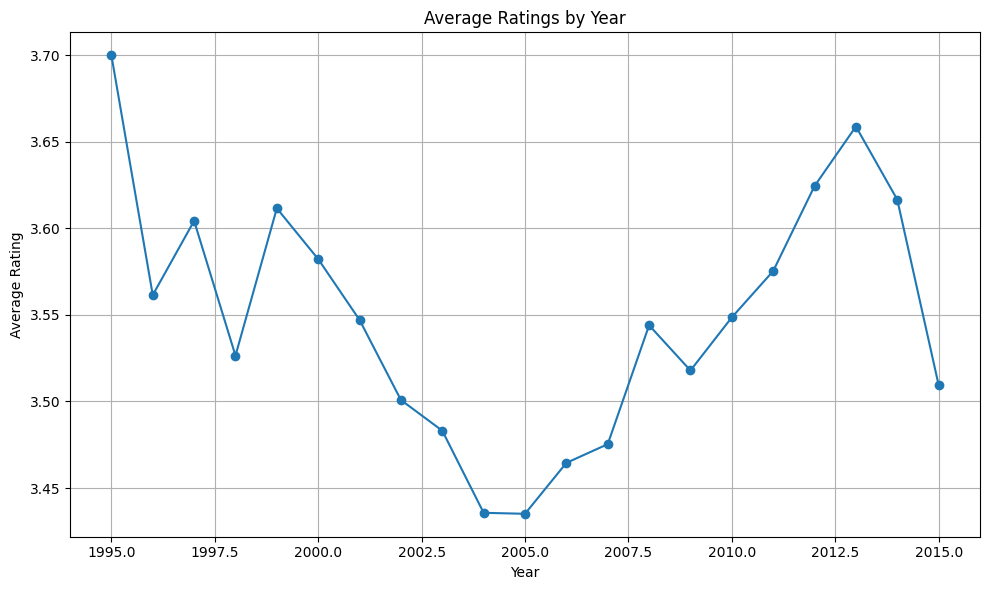

In [4]:
# Convert Spark DataFrames to Pandas for visualization
avg_ratings_by_genre_pd = avg_ratings_by_genre.toPandas()
ratings_by_year_pd = ratings_by_year.toPandas()

# Plot average ratings by genre
plt.figure(figsize=(10, 6))
avg_ratings_by_genre_pd.plot(kind="bar", x="genre", y="average_rating", legend=False)
plt.title("Average Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot ratings by year
plt.figure(figsize=(10, 6))
plt.plot(ratings_by_year_pd["year"], ratings_by_year_pd["average_rating"], marker="o")
plt.title("Average Ratings by Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid()
plt.tight_layout()
plt.show()

## other

In [6]:
# Preprocess movies and ratings data
movies_ratings_df = preprocess_movies_ratings(movie_df, rating_df)

# Calculate average ratings by genre
avg_ratings_by_genre = calculate_avg_ratings_by_genre(movies_ratings_df)

# Calculate ratings by year
ratings_by_year = calculate_ratings_by_year(movies_ratings_df)

# Save results for external use
save_to_csv(avg_ratings_by_genre, f"{path}/avg_ratings_by_genre.csv")
save_to_csv(ratings_by_year, f"{path}/ratings_by_year.csv")

<Figure size 1000x600 with 0 Axes>

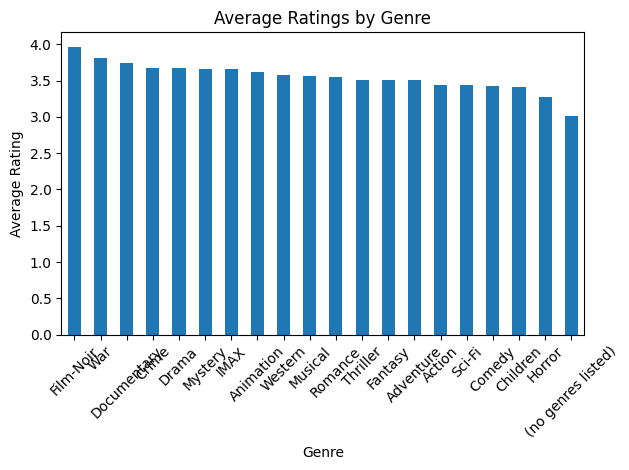

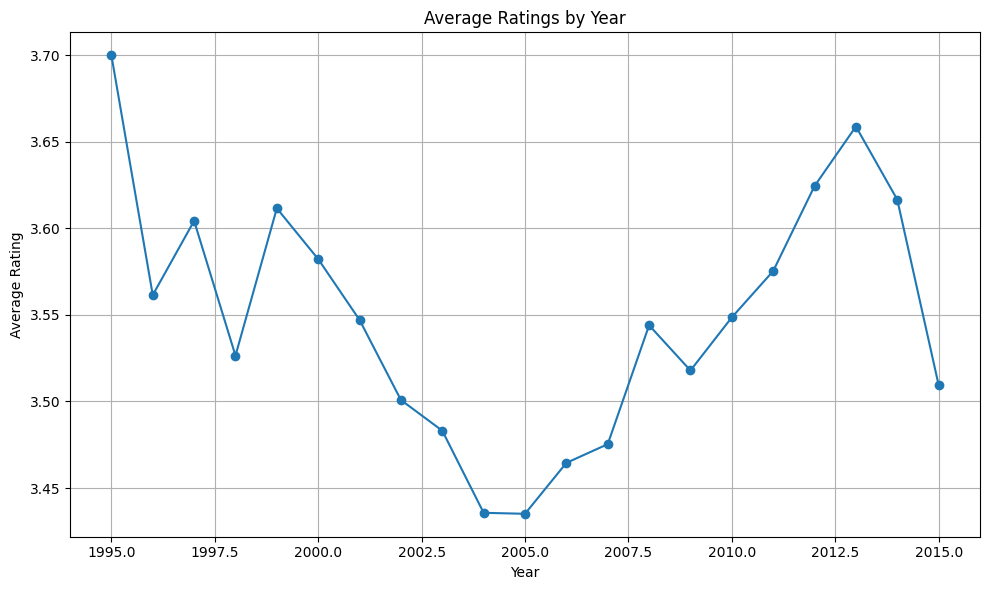

24/11/25 19:12:22 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 931149 ms exceeds timeout 120000 ms
24/11/25 19:12:22 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/25 19:12:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [7]:
# Convert Spark DataFrames to Pandas for visualization
avg_ratings_by_genre_pd = avg_ratings_by_genre.toPandas()
ratings_by_year_pd = ratings_by_year.toPandas()

# Plot average ratings by genre
plt.figure(figsize=(10, 6))
avg_ratings_by_genre_pd.plot(kind="bar", x="genre", y="average_rating", legend=False)
plt.title("Average Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot ratings by year
plt.figure(figsize=(10, 6))
plt.plot(ratings_by_year_pd["year"], ratings_by_year_pd["average_rating"], marker="o")
plt.title("Average Ratings by Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid()
plt.tight_layout()
plt.show()

1.2###

## **1.2 Minhash Signatures**
Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

**Important**: Implement your MinHash function from scratch—do not use any pre-built hash functions.
Use your MinHash function to generate signature vectors for each user based on their rated movies.
Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.
Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the book may be helpful as a reference.

In [2]:
# Import necessary libraries and functions
from pyspark.sql.functions import collect_set, col
from libs.minhash_functions import MinHashSpark
import matplotlib.pyplot as plt

from libs.analysis_functions import (
    initialize_spark, load_data, preprocess_movies_ratings,
    calculate_avg_ratings_by_genre, calculate_ratings_by_year,
    inspect_data, save_to_csv
)

# Initialize Spark
spark = initialize_spark()

# Define dataset path
path = "/Users/roberto/Desktop/HM4-ADM/datasets"

# Load Data
tag_df, rating_df, movie_df, link_df, genome_scores_df, genome_tags_df = load_data(spark, path)

# Preprocess movies and ratings data
movies_ratings_df = preprocess_movies_ratings(movie_df, rating_df)

# Aggregate movies watched by each user
user_movies_df = (
    movies_ratings_df
    .groupBy("userId")
    .agg(collect_set("movieId").alias("movieIds"))
)

# Initialize MinHash
num_hashes = 50
minhash = MinHashSpark(num_hashes=num_hashes)

# Compute MinHash signatures
user_movies_with_signature = user_movies_df.withColumn(
    "signature", minhash.compute_signature_udf()(col("movieIds"))
)

# Inspect the signatures
print("User MinHash Signatures:")
inspect_data(user_movies_with_signature, num_rows=5)

# Example: Compute Jaccard similarity between the first two users
users = user_movies_with_signature.limit(2).collect()
user1_sig = users[0]["signature"]
user2_sig = users[1]["signature"]
similarity = minhash.jaccard_similarity(user1_sig, user2_sig)

print(f"Jaccard Similarity (MinHash) between User 1 and User 2: {similarity:.4f}")

# Visualize Jaccard similarities for all users
user_signatures = user_movies_with_signature.collect()
similarities = []
for i in range(len(user_signatures)):
    for j in range(i + 1, len(user_signatures)):
        sim = minhash.jaccard_similarity(
            user_signatures[i]["signature"],
            user_signatures[j]["signature"]
        )
        similarities.append(sim)

# Plot similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=30, alpha=0.7)
plt.title("Jaccard Similarity Distribution Between Users (MinHash)")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Experiment with threshold values
thresholds = [0.2, 0.4, 0.6, 0.8]
results = []

for threshold in thresholds:
    similar_pairs = sum(1 for sim in similarities if sim >= threshold)
    results.append((threshold, similar_pairs))

# Plot results
threshold_df = pd.DataFrame(results, columns=["Threshold", "Number of Similar Pairs"])
threshold_df.plot(x="Threshold", y="Number of Similar Pairs", kind="bar", legend=False)
plt.title("Number of Similar User Pairs at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Number of Pairs")
plt.tight_layout()
plt.show()

User MinHash Signatures:


+------+--------------------+--------------------+
|userId|            movieIds|           signature|
+------+--------------------+--------------------+
|    26|[356, 589, 539, 3...|[3813, 977, 182, ...|
|    27|[3508, 539, 235, ...|[1108, 169, 38, 8...|
|    28|[161, 356, 509, 3...|[3813, 977, 182, ...|
|    31|[4366, 78469, 330...|[1207, 153, 162, ...|
|    34|[466, 356, 589, 6...|[25, 272, 182, 34...|
+------+--------------------+--------------------+
only showing top 5 rows



Jaccard Similarity (MinHash) between User 1 and User 2: 0.0400


: 

: 

It’s normal for MinHash computations to take some time, especially when the dataset is large and you’re generating multiple hash signatures for each user. However, there are optimizations and improvements you can make to reduce runtime.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MovieLens Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

24/11/25 21:48:33 WARN Utils: Your hostname, Robertos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.51 instead (on interface en0)
24/11/25 21:48:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 21:48:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
user_movies_df = (
    movies_ratings_df
    .groupBy("userId")
    .agg(collect_set("movieId").alias("movieIds"))
    .limit(500)  # Use only 500 users for testing
)

In [4]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

def calculate_jaccard(sig1, sig2):
    """
    Compute Jaccard similarity between two signatures.
    """
    intersection = len(set(sig1) & set(sig2))
    union = len(set(sig1) | set(sig2))
    return float(intersection) / float(union) if union != 0 else 0.0

# Register as UDF
jaccard_udf = udf(calculate_jaccard, FloatType())

# Generate all pairs of users
user_pairs = user_movies_with_signature.alias("u1").crossJoin(
    user_movies_with_signature.alias("u2")
).filter(col("u1.userId") < col("u2.userId"))

# Compute similarities
user_pairs_with_similarity = user_pairs.withColumn(
    "similarity",
    jaccard_udf(col("u1.signature"), col("u2.signature"))
)

# Filter based on a threshold
threshold = 0.2
similar_users = user_pairs_with_similarity.filter(col("similarity") >= threshold)

similar_users.show(5)  # Inspect results

+------+--------------------+--------------------+------+--------------------+--------------------+----------+
|userId|            movieIds|           signature|userId|            movieIds|           signature|similarity|
+------+--------------------+--------------------+------+--------------------+--------------------+----------+
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|    28|[161, 356, 509, 3...|[5294, 9540, 5117...|0.22222222|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   108|[466, 356, 589, 5...|[247, 5157, 280, ...|0.20731707|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   183|[161, 589, 153, 2...|[4294, 1088, 280,...|0.20987654|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   243|[356, 153, 590, 3...|[10392, 1088, 280...|0.25316456|
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|   296|[153, 1, 590, 2, ...|[2596, 5314, 1720...|0.22222222|
+------+--------------------+--------------------+------+--------------------+--------------------+----------+
o

In [5]:
print("Inspecting intermediate results...")
inspect_data(user_movies_with_signature, num_rows=5)

Inspecting intermediate results...


+------+--------------------+--------------------+
|userId|            movieIds|           signature|
+------+--------------------+--------------------+
|    26|[356, 589, 539, 3...|[796, 1088, 280, ...|
|    27|[3508, 539, 235, ...|[1204, 4441, 1157...|
|    28|[161, 356, 509, 3...|[5294, 9540, 5117...|
|    31|[4366, 78469, 330...|[306, 493, 86, 13...|
|    34|[466, 356, 589, 6...|[996, 7592, 538, ...|
+------+--------------------+--------------------+
only showing top 5 rows



In [6]:
spark = SparkSession.builder \
    .appName("MovieLens Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "100s") \
    .getOrCreate()

24/11/25 21:49:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## *Optimizations*, 
#### I need to put this in libs.py soon

In [9]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col, lit
import numpy as np
import random
import matplotlib.pyplot as plt

# Initialize Spark
def initialize_spark(app_name="Movie Recommendation System"):
    return SparkSession.builder.appName(app_name).getOrCreate()

# Load data
def load_data(spark, path):
    rating_df = spark.read.csv(f"{path}/rating.csv", header=True, inferSchema=True)
    return rating_df

# MinHash Function (Implemented from scratch)
class MinHash:
    def __init__(self, num_hashes):
        self.num_hashes = num_hashes
        self.hash_functions = self._generate_hash_functions()

    def _generate_hash_functions(self):
        # Generate random coefficients for hash functions
        max_val = 2**32 - 1
        return [
            (random.randint(1, max_val), random.randint(1, max_val))
            for _ in range(self.num_hashes)
        ]

    def compute_signature(self, user_movies):
        """
        Compute the MinHash signature for a set of movies (user_movies).
        """
        signature = []
        for a, b in self.hash_functions:
            min_hash = min((a * movie + b) % (10**9 + 7) for movie in user_movies)
            signature.append(min_hash)
        return signature

# Locality-Sensitive Hashing (LSH)
class LSH:
    def __init__(self, num_bands, rows_per_band):
        self.num_bands = num_bands
        self.rows_per_band = rows_per_band

    def hash_signature(self, signature):
        """
        Group MinHash signature into bands and hash each band.
        """
        assert len(signature) == self.num_bands * self.rows_per_band
        band_hashes = []
        for i in range(self.num_bands):
            band = tuple(signature[i * self.rows_per_band:(i + 1) * self.rows_per_band])
            band_hashes.append(hash(band))
        return band_hashes

# Preprocess the data
def preprocess_data(rating_df):
    """
    Group movies watched by each user and return a DataFrame with userId and movieIds.
    """
    user_movies_df = rating_df.groupBy("userId").agg(collect_set("movieId").alias("movieIds"))
    return user_movies_df

# Jaccard Similarity
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

def generate_recommendations(user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets):
    """
    Generate movie recommendations for a given user using LSH buckets.
    """
    # Find similar users in the same LSH buckets
    if user_id not in user_to_buckets:
        print(f"User {user_id} not found in LSH buckets.")
        return []

    user_bands = user_to_buckets[user_id]
    similar_users = set()
    for band_hash in user_bands:
        if band_hash in lsh_buckets:
            similar_users.update(lsh_buckets[band_hash])

    similar_users.discard(user_id)  # Remove the user itself from similar users

    # Aggregate movies watched by similar users, excluding movies already watched
    user_movies = set(user_movies_df.filter(col("userId") == user_id).collect()[0]["movieIds"])
    candidate_movies = set()
    for similar_user in similar_users:
        similar_user_movies = set(user_movies_df.filter(col("userId") == similar_user).collect()[0]["movieIds"])
        candidate_movies.update(similar_user_movies)
    
    recommendations = candidate_movies - user_movies
    return recommendations

# Main Recommendation System Implementation
def recommendation_system(path, num_hashes=50, num_bands=5):
    """
    Full implementation of the recommendation system.
    """
    spark = initialize_spark()

    # Load data
    rating_df = load_data(spark, path)

    # Preprocess data
    user_movies_df = preprocess_data(rating_df)

    # Initialize MinHash
    minhash = MinHash(num_hashes=num_hashes)

    # Compute MinHash signatures for all users
    user_signatures = {}
    for row in user_movies_df.collect():
        user_id = row["userId"]
        movie_ids = row["movieIds"]
        user_signatures[user_id] = minhash.compute_signature(movie_ids)

    # Initialize LSH
    rows_per_band = num_hashes // num_bands
    lsh = LSH(num_bands=num_bands, rows_per_band=rows_per_band)

        # Create LSH buckets and user-to-bucket mappings
    lsh_buckets = {}
    user_to_buckets = {}

    for user_id, signature in user_signatures.items():
        band_hashes = lsh.hash_signature(signature)
        user_to_buckets[user_id] = band_hashes  # Map user to their bands
        for band_hash in band_hashes:
            if band_hash not in lsh_buckets:
                lsh_buckets[band_hash] = []
            lsh_buckets[band_hash].append(user_id)

    # Generate Recommendations for a sample user
    sample_user_id = 1
    recommendations = generate_recommendations(sample_user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets)

    print(f"Recommended movies for User {sample_user_id}: {recommendations}")

# Call the recommendation system
if __name__ == "__main__":
    dataset_path = "/Users/roberto/Desktop/HM4-ADM/datasets"
    recommendation_system(dataset_path, num_hashes=50, num_bands=5)

Recommended movies for User 1: set()


## **1.3 Locality-Sensitive Hashing (LSH)**
Now that you have generated MinHash user signatures, apply Locality-Sensitive Hashing (LSH) to cluster similar users.

Bucket Creation: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

Debugging Tip: After creating buckets, check a few bucket contents to verify that multiple users are being grouped in the same buckets.
Query: For a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.

Movie Recommendation Logic:

If both similar users have rated a movie, recommend this movie based on the average rating.
If there are no commonly rated movies, recommend the top-rated movies of the most similar user.
Final Recommendation: Provide at most five movies to the user.

Example recommendation logic for a user:

| User | Movie Title  | Rating |
|------|--------------|--------|
| A    | Inception    | 4.5    |
| A    | Titanic      | 4.2    |
| A    | Avatar       | 2.8    |
| B    | Inception    | 4.6    |
| B    | The Matrix   | 3.9    |
| B    | Toy Story    | 4.7    |
| C    | Titanic      | 3.8    |
| C    | Avatar       | 4.3    |
| C    | Shrek        | 4.1    |

If User A and User B are identified as the two most similar users to User X, the recommended movies would be:

Common Movies: "Inception" (average rating: 4.55).
Top-rated from Most Similar User: "Toy Story" (4.7) from User B and "Titanic" (4.2) from User A.
If fewer than 5 movies are found, complete the list using other high-rated movies by the most similar users.

In [10]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col
from pyspark.sql.types import IntegerType
import random
import matplotlib.pyplot as plt
import pandas as pd

# MinHash Implementation
class MinHash:
    def __init__(self, num_hashes=50):
        self.num_hashes = num_hashes
        self.hash_funcs = self.generate_hash_functions()

    def generate_hash_functions(self):
        """
        Generate a list of hash functions of the form:
        h(x) = (a * x + b) % p
        """
        p = 2**31 - 1  # Large prime number
        hash_funcs = []
        for _ in range(self.num_hashes):
            a = random.randint(1, p - 1)
            b = random.randint(0, p - 1)
            hash_funcs.append((a, b))
        return hash_funcs

    def compute_signature(self, movie_ids):
        """
        Compute the MinHash signature for a given list of movie IDs.
        """
        signature = []
        for a, b in self.hash_funcs:
            min_hash = min((a * x + b) % (2**31 - 1) for x in movie_ids)
            signature.append(min_hash)
        return signature

# LSH Implementation
class LSH:
    def __init__(self, num_bands):
        self.num_bands = num_bands

    def hash_signature(self, signature):
        """
        Hash a signature into `num_bands` bands.
        """
        band_size = len(signature) // self.num_bands
        band_hashes = []
        for i in range(self.num_bands):
            band = signature[i * band_size: (i + 1) * band_size]
            band_hash = hash(tuple(band))
            band_hashes.append(band_hash)
        return band_hashes

# Spark Session Initialization
def initialize_spark(app_name="Movie Recommendation System"):
    return SparkSession.builder.appName(app_name).getOrCreate()

# Load Dataset
def load_data(spark, path):
    """
    Load MovieLens datasets into Spark DataFrames.
    """
    rating_df = spark.read.csv(f"{path}/rating.csv", header=True, inferSchema=True)
    movie_df = spark.read.csv(f"{path}/movie.csv", header=True, inferSchema=True)
    return rating_df, movie_df

# Preprocessing
def preprocess_data(rating_df):
    """
    Preprocess ratings data to create a list of movies watched by each user.
    """
    user_movies_df = (
        rating_df.groupBy("userId")
        .agg(collect_set("movieId").alias("movieIds"))
    )
    return user_movies_df

# Generate Recommendations
def generate_recommendations(user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets):
    """
    Generate movie recommendations for a given user using LSH buckets.
    """
    if user_id not in user_to_buckets:
        print(f"[ERROR] User {user_id} not found in LSH buckets.")
        return []

    user_bands = user_to_buckets[user_id]
    similar_users = set()
    for band_hash in user_bands:
        if band_hash in lsh_buckets:
            similar_users.update(lsh_buckets[band_hash])

    similar_users.discard(user_id)
    user_movies = set(user_movies_df.filter(col("userId") == user_id).collect()[0]["movieIds"])
    candidate_movies = set()
    for similar_user in similar_users:
        similar_user_movies = set(user_movies_df.filter(col("userId") == similar_user).collect()[0]["movieIds"])
        candidate_movies.update(similar_user_movies)

    recommendations = candidate_movies - user_movies
    return recommendations

# Recommendation System Workflow
def recommendation_system(dataset_path, num_hashes=50, num_bands=5):
    # Step 1: Initialize Spark
    spark = initialize_spark()

    # Step 2: Load Data
    rating_df, movie_df = load_data(spark, dataset_path)

    # Step 3: Preprocess Data
    user_movies_df = preprocess_data(rating_df)

    # Step 4: MinHash Signature Computation
    minhash = MinHash(num_hashes=num_hashes)
    user_signatures = {}
    for row in user_movies_df.collect():
        user_signatures[row["userId"]] = minhash.compute_signature(row["movieIds"])

    # Step 5: Locality-Sensitive Hashing (LSH)
    lsh = LSH(num_bands=num_bands)
    lsh_buckets = {}
    user_to_buckets = {}

    for user_id, signature in user_signatures.items():
        band_hashes = lsh.hash_signature(signature)
        user_to_buckets[user_id] = band_hashes
        for band_hash in band_hashes:
            if band_hash not in lsh_buckets:
                lsh_buckets[band_hash] = []
            lsh_buckets[band_hash].append(user_id)

    # Debugging: Print the first 5 LSH buckets
    print("\n=== Debug: LSH Buckets ===")
    for band_hash, users in list(lsh_buckets.items())[:5]:
        print(f"Band {band_hash}: Users: {users}")

    # Step 6: Generate Recommendations for a Sample User
    sample_user_id = 1
    print(f"\nGenerating recommendations for User {sample_user_id}...")
    recommendations = generate_recommendations(sample_user_id, user_movies_df, user_signatures, lsh_buckets, user_to_buckets)
    print(f"Recommended movies for User {sample_user_id}: {recommendations}")

    # Stop Spark session
    spark.stop()

# Run the Recommendation System
if __name__ == "__main__":
    dataset_path = "/Users/roberto/Desktop/HM4-ADM/datasets"  # Replace with your dataset path
    recommendation_system(dataset_path, num_hashes=50, num_bands=5)


=== Debug: LSH Buckets ===
Band 6821600883028769853: Users: [26, 89161, 109402, 109868, 124974, 51390, 67619, 82344, 102935, 37787, 89732, 110709, 126692, 26457, 38363, 58033, 65923, 70904, 90598, 130778, 32722, 40660, 52348, 86848, 100164, 42494, 74529, 136445, 20499, 30910, 56743, 68009, 71415, 83937, 95144, 120289, 1792, 32401, 32543, 53036, 80039, 90305, 122210, 12275, 65506, 70607, 98638, 31506, 75078, 116750, 129849]
Band 7212512039103131734: Users: [26]
Band 8885120358753260375: Users: [26, 3936, 13967, 37409, 55869, 62791, 67385, 78466, 90818, 108835, 20422, 27513, 27952, 43893, 51390, 75290, 96079, 104404, 133784, 13, 9776, 10396, 11212, 22160, 27765, 36186, 70057, 76529, 95430, 113481, 115583, 124935, 132743, 51443, 69954, 74996, 84261, 107703, 118404, 128474, 129503, 19727, 21611, 29429, 45433, 62908, 83451, 87141, 91320, 94776, 100179, 107492, 119076, 130317, 35748, 36800, 45058, 46535, 49779, 58930, 62959, 81214, 85173, 98676, 135496, 135582, 137397, 11688, 11953, 23376, 

Recommended movies for User 1: set()
